--- Script Initialization ---
--- Configuring Paths and Parameters ---
Output directory: assignment_outputs_q4_clipseg_refactored
Using device: cuda
--- Helper Functions Defined ---

--- Starting Main Execution ---

--- Installing/Verifying Dependencies ---
Installing transformers, Pillow, matplotlib, numpy...
Basic libraries installed/verified.
Transformers library verified.

--- Loading CLIPSeg Model (CIDAS/clipseg-rd64-refined) ---
CLIPSeg processor and model loaded successfully.

Reading reference texts from: /kaggle/input/cv-homework-3/reference/reference.txt
Loaded reference texts for 0 unique image filenames.

Generated new failure case texts for 10 images.

Searching for images in: /kaggle/input/cv-homework-3/reference/samples_q3_q4
Found 10 images.

--- Q4.2: Segmentation (Provided Refs using CLIPSeg) ---
Skipping Q4.2: No reference texts loaded.

--- Q4.3: Feature Maps (Simulated via CLIPSeg Heatmaps) ---
Skipping Q4.3: No results stored from Q4.2.

--- Q4.4: Failure Case Seg

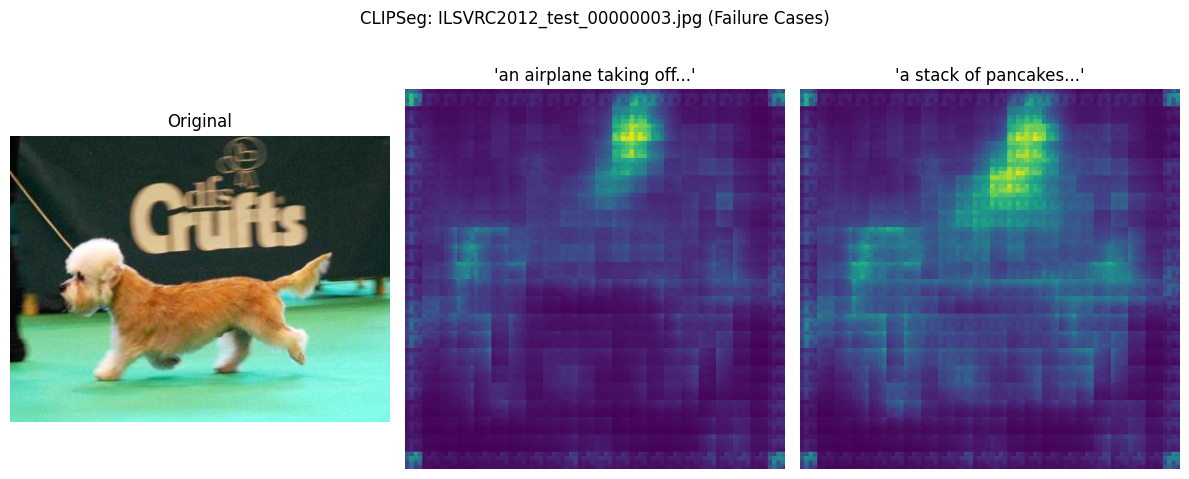

Processing ILSVRC2012_test_00000004.jpg (Failure): ['a busy city intersection', 'a boat sailing']
   -> Plot saved: assignment_outputs_q4_clipseg_refactored/Q4_Seg_ILSVRC2012_test_00000004.jpg_Failure_CLIPSeg.png


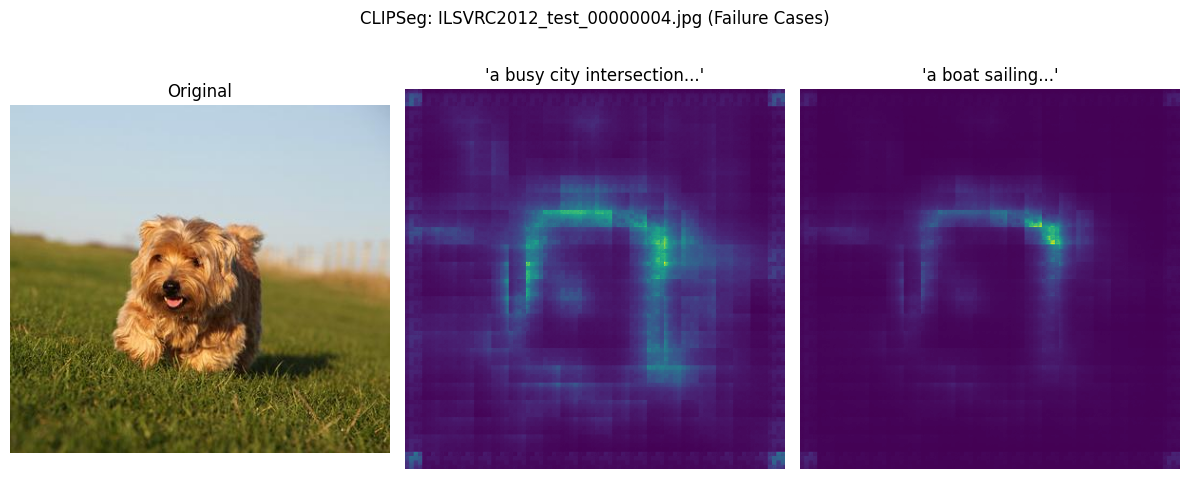

Processing ILSVRC2012_test_00000018.jpg (Failure): ['a cat sleeping on a keyboard', 'a snowy mountain peak']
   -> Plot saved: assignment_outputs_q4_clipseg_refactored/Q4_Seg_ILSVRC2012_test_00000018.jpg_Failure_CLIPSeg.png


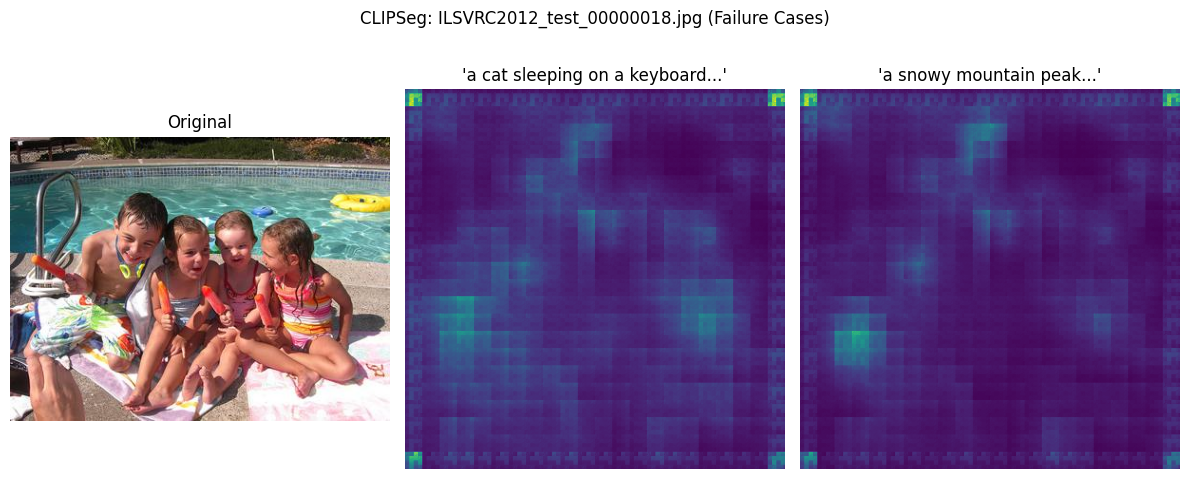

Processing ILSVRC2012_test_00000019.jpg (Failure): ['a red fire truck', 'a bowl of soup']
   -> Plot saved: assignment_outputs_q4_clipseg_refactored/Q4_Seg_ILSVRC2012_test_00000019.jpg_Failure_CLIPSeg.png


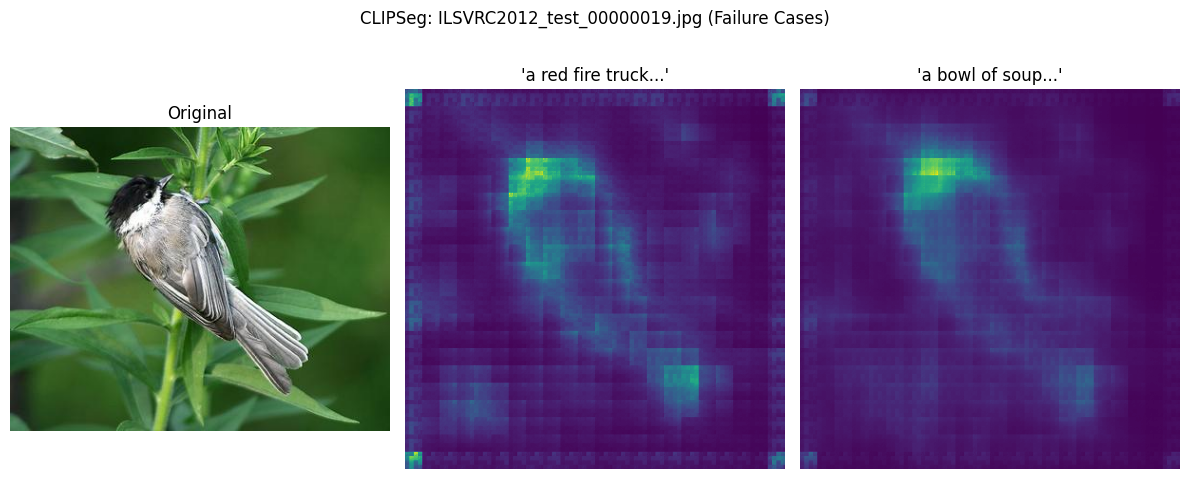

Processing ILSVRC2012_test_00000022.jpg (Failure): ['a helicopter in the sky', 'a bookshelf full of books']
   -> Plot saved: assignment_outputs_q4_clipseg_refactored/Q4_Seg_ILSVRC2012_test_00000022.jpg_Failure_CLIPSeg.png


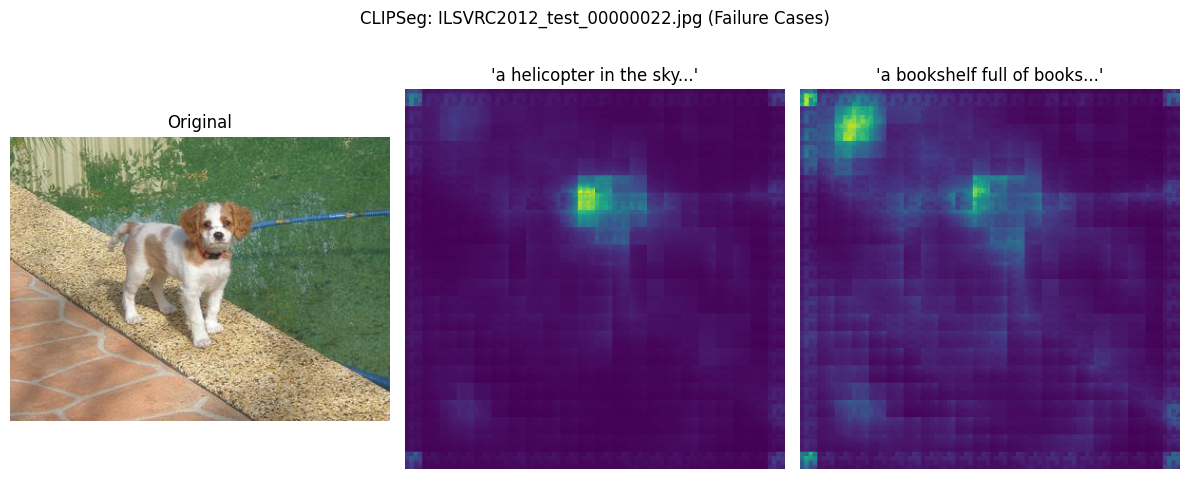

Processing ILSVRC2012_test_00000023.jpg (Failure): ['a plate of sushi', 'a running horse']
   -> Plot saved: assignment_outputs_q4_clipseg_refactored/Q4_Seg_ILSVRC2012_test_00000023.jpg_Failure_CLIPSeg.png


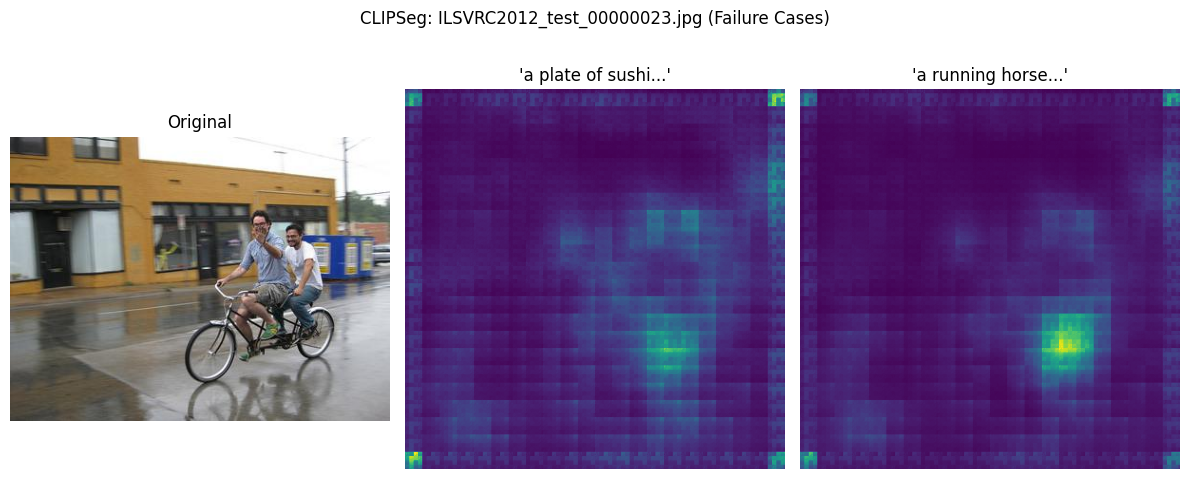

Processing ILSVRC2012_test_00000025.jpg (Failure): ['a desktop computer monitor', 'a bridge over a river']
   -> Plot saved: assignment_outputs_q4_clipseg_refactored/Q4_Seg_ILSVRC2012_test_00000025.jpg_Failure_CLIPSeg.png


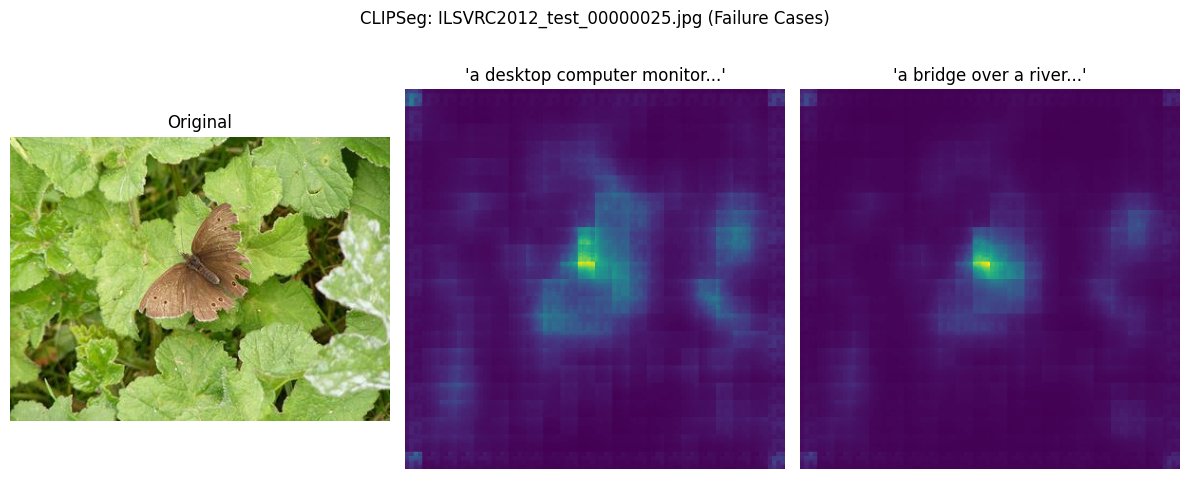

Processing ILSVRC2012_test_00000026.jpg (Failure): ['a sandy desert landscape', 'a basketball hoop']
   -> Plot saved: assignment_outputs_q4_clipseg_refactored/Q4_Seg_ILSVRC2012_test_00000026.jpg_Failure_CLIPSeg.png


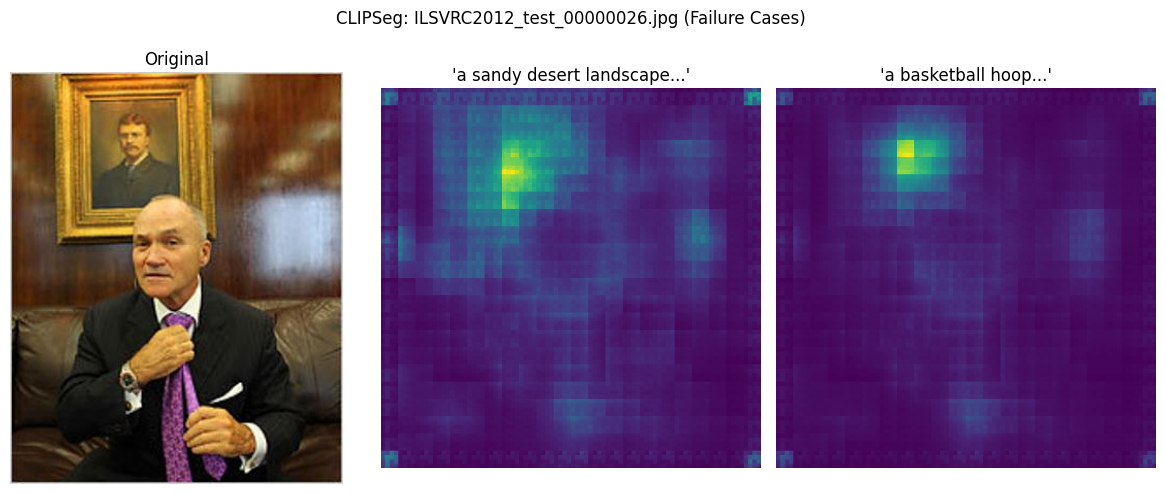

Processing ILSVRC2012_test_00000030.jpg (Failure): ['a plate of cookies', 'a train on tracks']
   -> Plot saved: assignment_outputs_q4_clipseg_refactored/Q4_Seg_ILSVRC2012_test_00000030.jpg_Failure_CLIPSeg.png


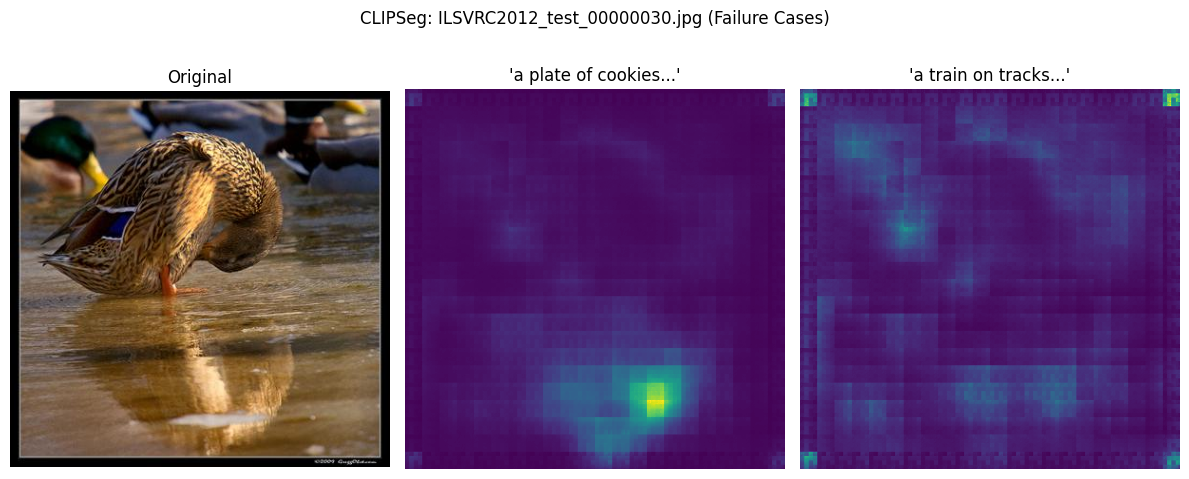

Processing ILSVRC2012_test_00000034.jpg (Failure): ['a pair of red shoes', 'a green forest']
   -> Plot saved: assignment_outputs_q4_clipseg_refactored/Q4_Seg_ILSVRC2012_test_00000034.jpg_Failure_CLIPSeg.png


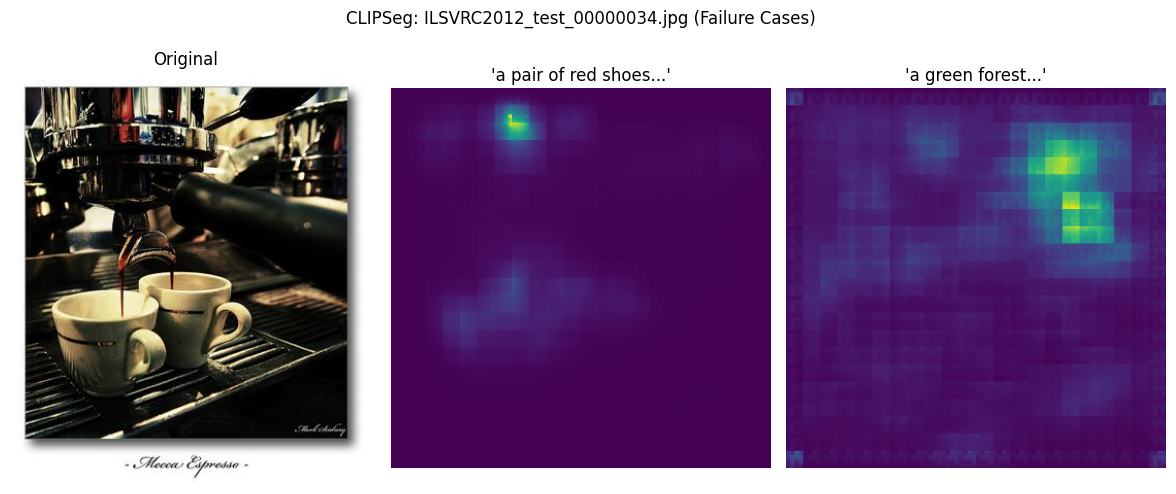


--- Main Execution Finished ---

--- End of Q4 (CLIPSeg Refactored) Script ---


In [4]:
# %% [code]
# ==============================================================================
# Question 4 - Referring Image Segmentation (CLIPSeg - Refactored)
# ==============================================================================
print("--- Script Initialization ---")

# %% [code]
# --- Core Imports ---
import torch
import os
import sys
import warnings
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import subprocess
from glob import glob
import re
import string
import traceback # For detailed error printing

# --- Suppress Warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# %% [code]
# --- Configuration ---
print("--- Configuring Paths and Parameters ---")
# Input Paths (Ensure these match your Kaggle dataset structure)
IMAGE_FOLDER_PATH = "/kaggle/input/cv-homework-3/reference/samples_q3_q4"
REFERENCE_TEXT_FILE = "/kaggle/input/cv-homework-3/reference/reference.txt"

# Output Directory
OUTPUT_DIR = "assignment_outputs_q4_clipseg_refactored"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

# Model Name
MODEL_NAME = "CIDAS/clipseg-rd64-refined"

# Device Selection
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# %% [code]
# --- Dependency Installation Function ---
def install_dependencies():
    """Installs necessary libraries using pip."""
    print("\n--- Installing/Verifying Dependencies ---")
    try:
        print("Installing transformers, Pillow, matplotlib, numpy...")
        subprocess.run([sys.executable, "-m", "pip", "install",
                        "torch>=1.9.0", "transformers", "Pillow",
                        "matplotlib", "numpy", "--quiet"], check=True)
        print("Basic libraries installed/verified.")
        # Verify transformers import explicitly
        from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
        print("Transformers library verified.")
        return True
    except ImportError as e:
        print(f"FATAL: Failed to import essential libraries after install: {e}")
        return False
    except subprocess.CalledProcessError as e:
        print(f"FATAL: pip installation failed: {e}")
        return False
    except Exception as e:
        print(f"FATAL: An unexpected error occurred during dependency setup: {e}")
        traceback.print_exc()
        return False

# %% [code]
# --- Model Loading Function ---
def load_clipseg_model(model_name, device):
    """Loads the CLIPSeg processor and model."""
    print(f"\n--- Loading CLIPSeg Model ({model_name}) ---")
    try:
        processor = CLIPSegProcessor.from_pretrained(model_name)
        model = CLIPSegForImageSegmentation.from_pretrained(model_name).to(device)
        model.eval()
        print("CLIPSeg processor and model loaded successfully.")
        return processor, model
    except Exception as e:
        print(f"Error loading CLIPSeg model: {e}")
        traceback.print_exc()
        return None, None

# %% [code]
# --- Data Loading Functions ---
def load_reference_texts(filepath):
    """Loads reference texts from the specified file."""
    reference_texts = {}
    print(f"\nReading reference texts from: {filepath}")
    if not os.path.exists(filepath):
        print(f"Error: Reference text file not found: {filepath}")
        return reference_texts # Return empty dict
    try:
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split(':', 1)
                if len(parts) == 2:
                    fname, txt = parts[0].strip(), parts[1].strip().strip('"')
                    # Store as list, even if only one text per image for now
                    reference_texts_q4.setdefault(fname, []).append(txt)
        print(f"Loaded reference texts for {len(reference_texts)} unique image filenames.")
    except Exception as e:
        print(f"Error reading reference file: {e}")
    return reference_texts

def get_image_files(directory):
    """Finds image files in the specified directory."""
    extensions = ['jpg', 'jpeg', 'png', 'bmp', 'JPEG', 'JPG', 'PNG']
    image_files = []
    if not os.path.isdir(directory):
        print(f"Error: Image directory not found - {directory}")
        return []
    print(f"\nSearching for images in: {directory}")
    for ext in extensions:
        image_files.extend(glob(os.path.join(directory, f"*.{ext}")))
    # Filter out hidden files
    image_files = [f for f in image_files if not os.path.basename(f).startswith('.')]
    print(f"Found {len(image_files)} images.")
    image_files.sort()
    return image_files

def generate_failure_prompts():
    """Creates a dictionary of new failure prompts for specific images."""
    # New, distinct failure prompts based on likely image content
    failure_prompts = {
        "ILSVRC2012_test_00000003.jpg": ["an airplane taking off", "a stack of pancakes"], # Dog walking
        "ILSVRC2012_test_00000004.jpg": ["a busy city intersection", "a boat sailing"],     # Dog in grass
        "ILSVRC2012_test_00000018.jpg": ["a cat sleeping on a keyboard", "a snowy mountain peak"], # Boy, ice cream
        "ILSVRC2012_test_00000019.jpg": ["a red fire truck", "a bowl of soup"],          # Bird
        "ILSVRC2012_test_00000022.jpg": ["a helicopter in the sky", "a bookshelf full of books"], # Dog near pool
        "ILSVRC2012_test_00000023.jpg": ["a plate of sushi", "a running horse"],       # Person on bicycle
        "ILSVRC2012_test_00000025.jpg": ["a desktop computer monitor", "a bridge over a river"], # Butterfly
        "ILSVRC2012_test_00000026.jpg": ["a sandy desert landscape", "a basketball hoop"], # Man in suit
        "ILSVRC2012_test_00000030.jpg": ["a plate of cookies", "a train on tracks"],        # Duck
        "ILSVRC2012_test_00000034.jpg": ["a pair of red shoes", "a green forest"],      # Coffee machine
    }
    print(f"\nGenerated new failure case texts for {len(failure_prompts)} images.")
    return failure_prompts

# %% [code]
# --- Helper Functions: Visualization & Utilities ---

def sanitize_filename(text, max_len=50):
    """Creates a safe filename from text."""
    valid_chars = "-_. %s%s" % (string.ascii_letters, string.digits)
    sanitized = ''.join(c for c in text if c in valid_chars)
    sanitized = sanitized.replace(' ', '_')
    sanitized = sanitized[:max_len]
    return sanitized if sanitized else "output"

def visualize_clipseg_output(image_pil, texts, preds_tensor, title="CLIPSeg Output", save_path=None):
    """Visualizes Original Image + CLIPSeg Heatmaps"""
    num_texts = len(texts)
    fig, axes = plt.subplots(1, num_texts + 1, figsize=(4 * (num_texts + 1), 5))
    if num_texts == 0: axes_flat = [axes] # Handle single plot case
    else: axes_flat = axes.flat

    # Plot Original Image
    axes_flat[0].imshow(image_pil); axes_flat[0].axis('off'); axes_flat[0].set_title("Original")

    # Plot Heatmaps
    if preds_tensor is not None:
        try:
            preds_np = preds_tensor.detach().cpu().float().numpy()
             # Ensure shape is (num_texts, H, W) even if only one text
            if preds_np.ndim == 2: preds_np = preds_np[np.newaxis, :, :]

            if preds_np.shape[0] == num_texts:
                for i, text in enumerate(texts):
                    heatmap = 1 / (1 + np.exp(-preds_np[i])).squeeze() # Sigmoid
                    axes_flat[i+1].imshow(heatmap, cmap='viridis')
                    axes_flat[i+1].axis('off')
                    axes_flat[i+1].set_title(f"'{text[:30]}...'")
            else:
                 print(f"Warning: Mismatch texts ({len(texts)}) vs preds ({preds_np.shape[0]})")
                 # Still plot placeholders
                 for i, text in enumerate(texts):
                      axes_flat[i+1].text(0.5, 0.5, 'Pred Error', ha='center', va='center')
                      axes_flat[i+1].axis('off')
                      axes_flat[i+1].set_title(f"'{text[:30]}...'")

        except Exception as e:
            print(f"Error during heatmap visualization: {e}")
            # Plot placeholders on error
            for i, text in enumerate(texts):
                axes_flat[i+1].text(0.5, 0.5, 'Viz Error', ha='center', va='center')
                axes_flat[i+1].axis('off')
                axes_flat[i+1].set_title(f"'{text[:30]}...'")
    else:
        print("Warning: No predictions provided for visualization.")
        # Plot placeholders if preds is None
        for i, text in enumerate(texts):
            axes_flat[i+1].text(0.5, 0.5, 'No Preds', ha='center', va='center')
            axes_flat[i+1].axis('off')
            axes_flat[i+1].set_title(f"'{text[:30]}...'")


    fig.suptitle(title, y=1.01); plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    if save_path: plt.savefig(save_path, bbox_inches='tight'); print(f"   -> Plot saved: {save_path}")
    plt.show(); plt.close(fig)

# Feature map visualization for CLIPSeg just shows the logits/heatmap again
def visualize_feature_map_clipseg(image_pil, texts, preds_tensor, title="CLIPSeg Feature Maps (Heatmap)", save_path=None):
     print("   (For CLIPSeg, 'Feature Map' shows the same output heatmap as segmentation)")
     visualize_clipseg_output(image_pil, texts, preds_tensor, title=title, save_path=save_path)

print("--- Helper Functions Defined ---")


# %% [code]
# --- Main Execution Function ---
def main():
    print("\n--- Starting Main Execution ---")

    # 1. Install Dependencies
    if not install_dependencies():
        print("Halting script due to dependency installation failure.")
        return

    # 2. Load Model
    processor, model = load_clipseg_model(MODEL_NAME, DEVICE)
    if processor is None or model is None:
        print("Halting script due to model loading failure.")
        return

    # 3. Load Data
    reference_texts = load_reference_texts(REFERENCE_TEXT_FILE)
    failure_texts = generate_failure_prompts()
    image_paths = get_image_files(IMAGE_FOLDER_PATH)

    if not image_paths:
        print("Halting script: No images found.")
        return

    # Storage for results (optional, if needed later)
    results_storage = {}

    # --- Run Q4.2: Segmentation (Provided Refs) ---
    print("\n--- Q4.2: Segmentation (Provided Refs using CLIPSeg) ---")
    processed_count_q42 = 0
    if not reference_texts:
        print("Skipping Q4.2: No reference texts loaded.")
    else:
        for img_path in image_paths:
            bname = os.path.basename(img_path)
            if bname not in reference_texts: continue
            texts = reference_texts[bname] # Get list of texts
            if not texts: continue

            print(f"Processing {bname} (Provided): {texts}")
            try:
                img_pil = Image.open(img_path).convert("RGB")
                inputs = processor(text=texts, images=[img_pil]*len(texts), padding="max_length", return_tensors="pt").to(DEVICE)
                with torch.no_grad():
                    outputs = model(**inputs)

                if hasattr(outputs, 'logits') and outputs.logits is not None:
                    # Store logits if needed elsewhere, e.g., for Q4.3
                    results_storage[img_path] = {'image': img_pil, 'texts_provided': texts, 'preds_provided': outputs.logits.cpu()}
                    # Visualize
                    save_p = os.path.join(OUTPUT_DIR, f"Q4_Seg_{sanitize_filename(bname)}_Provided_CLIPSeg.png")
                    visualize_clipseg_output(img_pil, texts, outputs.logits, title=f"CLIPSeg: {bname} (Provided Refs)", save_path=save_p)
                    processed_count_q42 += 1
                else:
                    print(f"Warning: No logits output found for {bname}.")
            except Exception as e:
                print(f"ERROR processing {bname} for Q4.2: {e}")
                traceback.print_exc()
        if processed_count_q42 == 0: print("No images processed for Q4.2.")


    # --- Run Q4.3: Feature Maps (Simulated via Heatmaps) ---
    print("\n--- Q4.3: Feature Maps (Simulated via CLIPSeg Heatmaps) ---")
    processed_count_q43 = 0
    if not results_storage:
        print("Skipping Q4.3: No results stored from Q4.2.")
    else:
        for img_path, data in results_storage.items():
             if 'preds_provided' in data:
                  bname = os.path.basename(img_path)
                  print(f"Visualizing 'feature map' for {bname}")
                  save_p = os.path.join(OUTPUT_DIR, f"Q4_FeatMap_{sanitize_filename(bname)}_CLIPSeg.png")
                  visualize_feature_map_clipseg(data['image'], data['texts_provided'], data['preds_provided'], title=f"CLIPSeg FeatMap: {bname}", save_path=save_p)
                  processed_count_q43 += 1
             # else: print(f"Skipping {os.path.basename(img_path)} for Q4.3 - No predictions found.")
        if processed_count_q43 == 0: print("No feature maps visualized.")


    # --- Run Q4.4: Failure Case Segmentation ---
    print("\n--- Q4.4: Failure Case Segmentation (using CLIPSeg) ---")
    processed_count_q44 = 0
    if not failure_texts:
        print("Skipping Q4.4: No failure texts generated.")
    else:
        for img_path in image_paths:
            bname = os.path.basename(img_path)
            if bname not in failure_texts: continue
            texts = failure_texts[bname] # Get list of failure texts
            if not texts: continue

            print(f"Processing {bname} (Failure): {texts}")
            try:
                img_pil = Image.open(img_path).convert("RGB")
                inputs = processor(text=texts, images=[img_pil]*len(texts), padding="max_length", return_tensors="pt").to(DEVICE)
                with torch.no_grad():
                     outputs = model(**inputs)

                if hasattr(outputs, 'logits') and outputs.logits is not None:
                     save_p = os.path.join(OUTPUT_DIR, f"Q4_Seg_{sanitize_filename(bname)}_Failure_CLIPSeg.png")
                     visualize_clipseg_output(img_pil, texts, outputs.logits, title=f"CLIPSeg: {bname} (Failure Cases)", save_path=save_p)
                     processed_count_q44 += 1
                else:
                     print(f"Warning: No logits output found for {bname} (failure case).")
            except Exception as e:
                 print(f"ERROR processing {bname} for Q4.4: {e}")
                 traceback.print_exc()
        if processed_count_q44 == 0: print("No failure cases processed.")

    print("\n--- Main Execution Finished ---")

# %% [code]
# --- Script Entry Point ---
if __name__ == "__main__":
    main()
    print("\n--- End of Q4 (CLIPSeg Refactored) Script ---")